In [1]:
# imports
import numpy as np

### What is the point of calibration?

* Ensure that predicted probalitilies match real world outcomes
* I.e. if a nn cannot confidently predict 1 or 0 for obstructions, the car sensor should rely more on the output of other sensors for braking

#### Definitions

Define **perfect calibration** as $ P(\hat{y} = y | \hat{p} = p) = p  $ 

The calibration $\hat{p}=p$ cannot be computed with finitely many samples since $\hat{p}$ is a continuous random variable.

If we have **perfect calibration** then a **reliability diagram** which plots the confidence $\hat{p}$ on the x axis and the accuracy $P(\hat{y} = y | \hat{p} = p)$ on the left should plot the identity function, a diagonal line, $y=x$.

To compute a **reliability diagram**, we bin samples based on their confidence, and calculate the accuracy of each bin, given that we also have $[0,1]$ labels.

In [2]:
"""
generate n x 3 data where 

col_1 is the calibration p, can generate uniformly between (0,1)
col_2 is the label y
col_3 is the predicted label y, so flip col_2 w.p. 1-p

How can we do a bit flip in python?

0 --> 1: 0 + 1 mod 2
1 --> 0: 1 + 1 mod 2

so generate the second operand as a binomial w.p. 1-p
"""

import random

N = 100


def binomialvariate(n,p):
    return sum(random.random() < p for i in range(n))

col_1 = [random.uniform(0,1) for _ in range(N)]
y = [random.randint(0,1) for _ in range(N)]
coin_flip = [binomialvariate(n=1,p=1-proba) for proba in col_1]

y_hat = [(x + y)% 2 for x,y in zip(y,coin_flip)]

data_array = np.array([col_1, y, y_hat])
data_array = data_array.T

In [3]:
# create M = 10 bins for [0,1] interval?
# create list(range(11)) = [0,1,...,9] = buckets 
# each data point is >= lower_bound and < upper_bound

# so if data point is in bucket[i] then data_point >= bucket_[i] and < bucket_[i+1]
# min bucket[i] where data_point is greater than bucket[i]

In [4]:
# sort by col_1, the confidence

# col_1 looks like [0.22, ..., 0.44]
# multiply by 10 then round down
# bucket_assignment = math.floor(item * 10)
import math

bins = [math.floor(item*10) for item in col_1]
# print(bins)

bins = np.array(bins)

idxs = np.argwhere(bins==9)

# col_1, y, y_hat
# data_array ....

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    accs.append(acc)

In [5]:
print(accs)

[0.0, 0.4, 0.3333333333333333, 0.3076923076923077, 0.42857142857142855, 0.5555555555555556, 0.7272727272727273, 0.5882352941176471, 0.5, 1.0]


In [6]:
buckets = list(range(10))

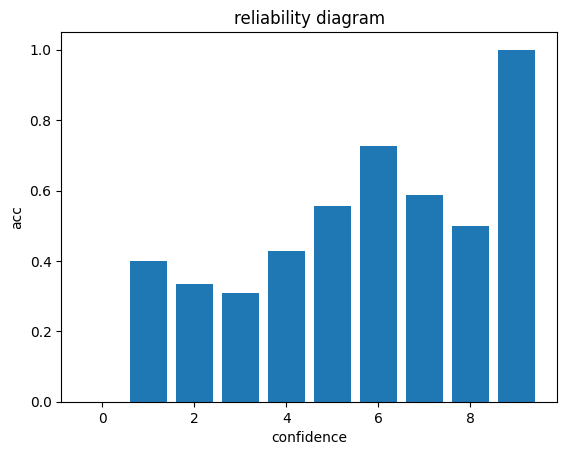

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(buckets, accs, label=buckets)
ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title('reliability diagram')

plt.show()

### Expected Calibration Error (ECE)

Prefer to have a scalar over a diagram

$ECE = \mathbb{E}_{\hat{p}} [\lvert P(\hat{y} = y | \hat{p} - p\rvert] = \sum_{m=1}^M \frac{\lvert B_m \rvert}{n} \vert acc(B_m) - conf(B_m) \vert $

In [8]:
# col_conf, y, y_hat
# data_array ....

ece = 0

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    bucket_size = len(idxs)
    conf = np.mean(data_array[idxs,0])
    ece += float(bucket_size/N) * abs(acc-conf)

print(ece)

0.08904113218841048


### What are some other ways to calibrate?

NLL, i.e. cross entropy loss, $ - \sum_{p(x)} \log q(x) $ , (Bengio et al 2015). According to (Friedman et al 2001), NLL is minimized iff $\hat{\pi}(y \vert x)$ recovers the ground truth conidtional distribution $\pi(y \vert x)$.

In practice, NLL, diverges from accuracy (Zhang et al 2017) so it is not a great calibration method in practice. 

### Platt Scaling and generalization to MultiClass Problems

What is **Platt scaling** (Platt et al, 1999)?
# https://home.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Platt1999.pdf

* A parametric approach to calibration
* The non-probabilistic predictions of a classifier are used as features for a logistic regression model, which is trained on the validation set to return probabilities
* I.e., learn $\hat{q_i} = \sigma(a z_i + b)$ as the calibrated probability using NLL over the validation set, while the NN parameters are fixed

### Matrix and vector scaling

* two multi-class extensions of Platt scaling. Apply linear transformation before the softmax
* $\hat{q_i} = max_k \sigma_{SM}(W z_i + b)$
* $\hat{y_i'} = argmax_k \sigma_{SM}(W z_i + b)$

* The parameters $W$ and $b$ are optimized wrt to NLL on the validation set.

In [9]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [11]:
print(type(testset[0]))
print(len(testset))
print(testset[0])

<class 'tuple'>
10000
(tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
         [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
         [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
         ...,
         [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
         [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
         [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],

        [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
         [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
         [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
         ...,
         [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
         [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
         [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],

        [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
         [-0.6000, -0.

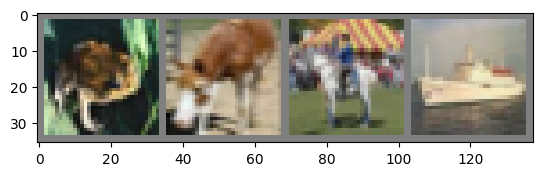

frog  horse horse ship 


In [12]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network

TODO(annhe): figure out how to calculate cnn inner layer dims

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.198
[1,  4000] loss: 1.855
[1,  6000] loss: 1.658
[1,  8000] loss: 1.580
[1, 10000] loss: 1.492
[1, 12000] loss: 1.438
[2,  2000] loss: 1.354
[2,  4000] loss: 1.338
[2,  6000] loss: 1.318
[2,  8000] loss: 1.274
[2, 10000] loss: 1.276
[2, 12000] loss: 1.252
[3,  2000] loss: 1.169
[3,  4000] loss: 1.177
[3,  6000] loss: 1.168
[3,  8000] loss: 1.155
[3, 10000] loss: 1.171
[3, 12000] loss: 1.165
[4,  2000] loss: 1.080
[4,  4000] loss: 1.106
[4,  6000] loss: 1.066
[4,  8000] loss: 1.087
[4, 10000] loss: 1.083
[4, 12000] loss: 1.085
Finished Training


In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # print(outputs.data.shape)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [18]:
# Freeze params of the CNN

for param in net.parameters():
    param.requires_grad = False

In [19]:
# define a new net, call it PlattNet

class PlattNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.matrix = nn.Linear(10, 10)

    def forward(self, x):
        x = self.matrix(x)
        x = F.softmax(x,dim=1)
        return x

plattnet = PlattNet()

for param in plattnet.parameters():
    param.requires_grad = True

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(plattnet.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(10):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = plattnet(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Calibration')

[1,  2000] loss: 2.109
[2,  2000] loss: 1.974
[3,  2000] loss: 1.949
[4,  2000] loss: 1.893
[5,  2000] loss: 1.883
[6,  2000] loss: 1.877
[7,  2000] loss: 1.874
[8,  2000] loss: 1.871
[9,  2000] loss: 1.869
[10,  2000] loss: 1.867
Finished Calibration


In [58]:
print(testset[0][0].shape)

torch.Size([3, 32, 32])


In [59]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

In [60]:
for param in plattnet.parameters():
    param.requires_grad = False

In [62]:
histogram_x = []
histogram_y = []

In [63]:
for epoch in range(1):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = plattnet(outputs)
        outputs = outputs.detach().numpy()
        labels = labels.detach().numpy()
        histogram_x.append(outputs)
        histogram_y.append(labels)
        

        if i % 100: print("data point: ", i)

print('Finished Collecting Calibrated Points')

data point:  1
data point:  2
data point:  3
data point:  4
data point:  5
data point:  6
data point:  7
data point:  8
data point:  9
data point:  10
data point:  11
data point:  12
data point:  13
data point:  14
data point:  15
data point:  16
data point:  17
data point:  18
data point:  19
data point:  20
data point:  21
data point:  22
data point:  23
data point:  24
data point:  25
data point:  26
data point:  27
data point:  28
data point:  29
data point:  30
data point:  31
data point:  32
data point:  33
data point:  34
data point:  35
data point:  36
data point:  37
data point:  38
data point:  39
data point:  40
data point:  41
data point:  42
data point:  43
data point:  44
data point:  45
data point:  46
data point:  47
data point:  48
data point:  49
data point:  50
data point:  51
data point:  52
data point:  53
data point:  54
data point:  55
data point:  56
data point:  57
data point:  58
data point:  59
data point:  60
data point:  61
data point:  62
data point:  63
d

In [66]:
print(histogram_x[0][0])

[9.3910048e-06 4.7368158e-04 3.6769360e-03 3.6190173e-03 4.9488372e-03
 6.5013784e-01 3.3180752e-01 2.8717009e-04 1.3716565e-03 3.6679246e-03]


In [69]:
res = np.max(histogram_x[0][0])
print(res)

0.65013784


In [74]:
y_gt_label = [x[0] for x in histogram_y]

In [70]:
predicted_confidence = [np.max(x[0]) for x in histogram_x]
predicted_class = [np.argmax(x[0]) for x in histogram_x]

bins = [math.floor(item*10) for item in predicted_confidence]

In [81]:
print(type(predicted_class))
predicted_class = np.array(predicted_class)
print(type(predicted_class))
y_gt_label = np.array(y_gt_label)
print(type(y_gt_label))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [85]:
bins = np.array(bins)
print(type(bins))

<class 'numpy.ndarray'>


In [86]:
accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    print("bin idxs: ", bin, idxs)
    # index into y, y_hat to calculate per bin accuracies
    y_preds = predicted_class[idxs]
    y_gt = y_gt_label[idxs]

    equals = y_preds == y_gt
    acc = np.mean(equals)
    accs.append(acc)

bin idxs:  0 []
bin idxs:  1 []
bin idxs:  2 [[ 162]
 [ 229]
 [ 262]
 [ 314]
 [ 381]
 [ 394]
 [ 541]
 [1032]
 [1227]
 [1228]
 [1418]
 [1775]
 [1906]
 [2321]
 [2525]
 [2599]
 [2633]
 [3023]
 [3391]
 [3602]
 [3669]
 [3996]
 [4169]
 [4170]
 [4217]
 [4570]
 [4820]
 [5100]
 [5172]
 [5211]
 [5213]
 [5283]
 [5467]
 [5486]
 [5491]
 [5506]
 [5535]
 [5657]
 [5854]
 [6046]
 [6440]
 [6637]
 [6756]
 [6811]
 [6876]
 [6895]
 [6948]
 [6970]
 [7126]
 [7150]
 [7562]
 [7744]
 [7839]
 [8199]
 [8201]
 [8357]
 [8911]
 [9039]
 [9100]
 [9107]
 [9464]]
bin idxs:  3 [[  30]
 [ 129]
 [ 343]
 [ 457]
 [ 459]
 [ 485]
 [ 526]
 [ 555]
 [ 573]
 [ 587]
 [ 650]
 [ 695]
 [ 729]
 [ 762]
 [ 773]
 [ 787]
 [ 798]
 [ 811]
 [ 819]
 [ 825]
 [ 846]
 [ 905]
 [ 966]
 [ 988]
 [ 995]
 [1058]
 [1123]
 [1130]
 [1157]
 [1208]
 [1304]
 [1395]
 [1398]
 [1525]
 [1534]
 [1538]
 [1638]
 [1649]
 [1689]
 [1705]
 [1739]
 [1804]
 [1821]
 [1940]
 [1941]
 [1975]
 [1979]
 [1995]
 [2032]
 [2108]
 [2159]
 [2167]
 [2351]
 [2388]
 [2449]
 [2512]
 [261

In [89]:
print(accs)
accs = [0 if math.isnan(x) else x for x in accs]
print(accs)

[nan, nan, 0.16393442622950818, 0.23333333333333334, 0.26631393298059963, 0.345679012345679, 0.4133180252583238, 0.41983122362869196, 0.5333333333333333, 0.7831439393939394]
[0, 0, 0.16393442622950818, 0.23333333333333334, 0.26631393298059963, 0.345679012345679, 0.4133180252583238, 0.41983122362869196, 0.5333333333333333, 0.7831439393939394]


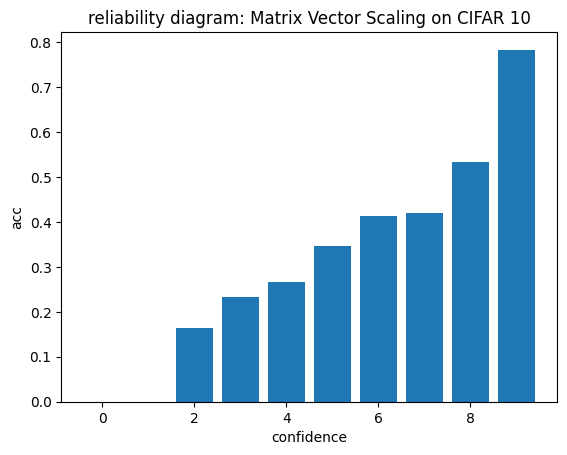

In [91]:
buckts = list(range(10))

fig, ax = plt.subplots()

ax.bar(buckets, accs, label=buckets)
ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title('reliability diagram: Matrix Vector Scaling on CIFAR 10')

plt.show()

### Temperature Scaling

